# Esercitazione 6 - Alberi di Decisione

Oggi introduciamo algoritmi che utilizzano regole di decisione per calcolare risposte.

<a target="_blank" href="https://colab.research.google.com/github/zangobot/BusinessAnalytics_TeachingMaterial/blob/main/Esercitazione%206%20-%20Alberi%20di%20Decisione.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Alberi

Un Albero di decisione (Decision Tree) è un classificatore **non-lineare** basato su regole inferite dai dati.
Dato un insieme di osservazioni, un albero di decisione inizia a creare regioni di spazio, creando una regola di decisione che meglio divide i dati una feature alla volta.

<img src="https://i.stack.imgur.com/vaoPn.png">

Quindi, regola dopo regola, l'algoritmo assume la forma di un albero, i cui nodi sono tutte le regole create.
Le foglie contengono i risultati, ossia la classe predetta in caso di problemi di classificazione, oppure un valore numerico in caso di regressione.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('dati/penguins_size.csv').dropna()

In [2]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, encoder, **params):
    Z = encoder.transform(clf.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_decision_region(clf, X, Y, title, x_label, y_label, classes, color='rgb'):
    colors = cycle(color)
    encoder = LabelEncoder().fit(Y)
    X0, X1 = X[x_label], X[y_label]
    xx, yy = make_meshgrid(X0, X1)
    fig, ax = plt.subplots()
    plot_contours(ax, clf, xx, yy, encoder, cmap=plt.cm.coolwarm, alpha=0.8)
    for c in classes:
        X[Y == c].plot.scatter(x_label, y_label, ax=ax, color=next(colors), label=c)
    ax.set_title(title)

/Users/zangobot/miniconda3/envs/ba2223/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


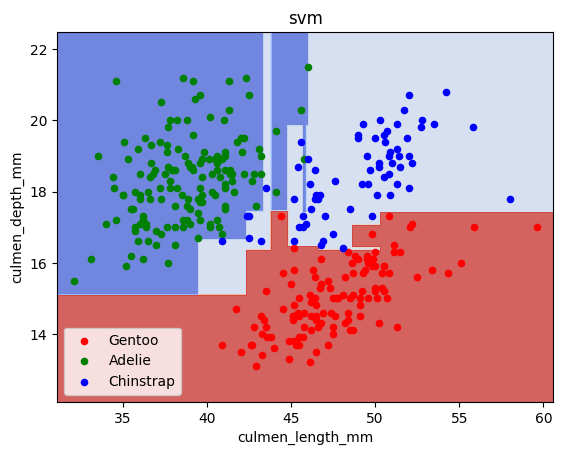

In [3]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

X, Y = data[['culmen_length_mm', 'culmen_depth_mm']], data['species']

clf.fit(X, Y)
plot_decision_region(clf, X, Y, 'decision tree', 'culmen_length_mm', 'culmen_depth_mm', classes=["Gentoo", "Adelie", "Chinstrap"])

Anche l'algoritmo Decision Tree ha molti parametri che si possono aggiustare, in questa esercitazione ne vediamo uno in particolare: la profondità.
Questo parametro regola il numero di divisioni dello spazio che l'albero crea sui dati.
Proviamo a cambiare il valore della profondità e vediamo cosa succede.

/Users/zangobot/miniconda3/envs/ba2223/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/zangobot/miniconda3/envs/ba2223/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/zangobot/miniconda3/envs/ba2223/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/zangobot/miniconda3/envs/ba2223/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/zangobot/miniconda3/envs/ba2223/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Decis

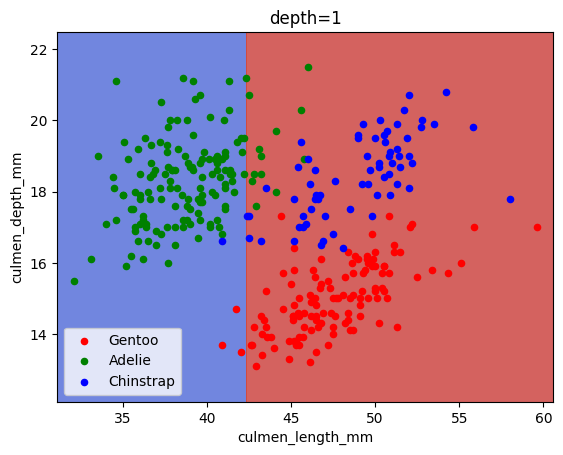

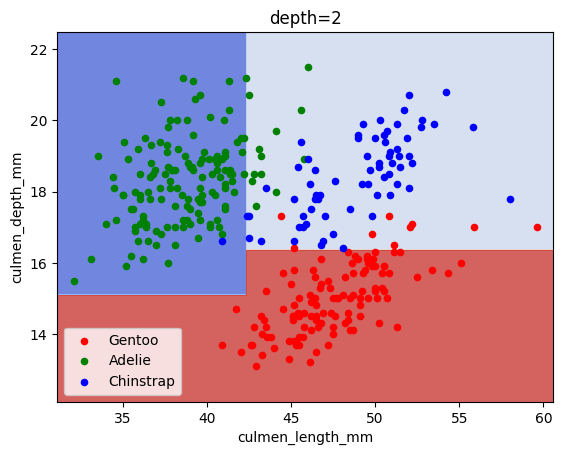

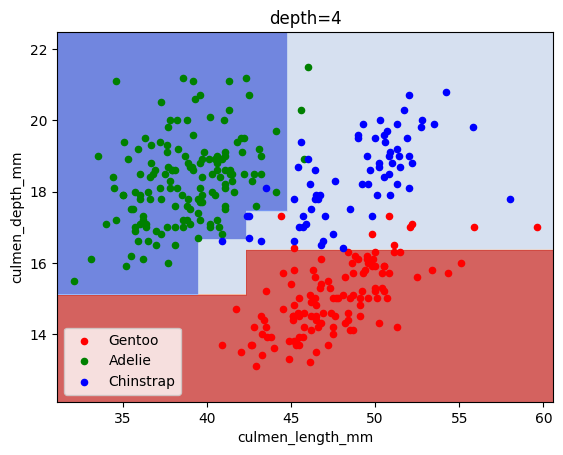

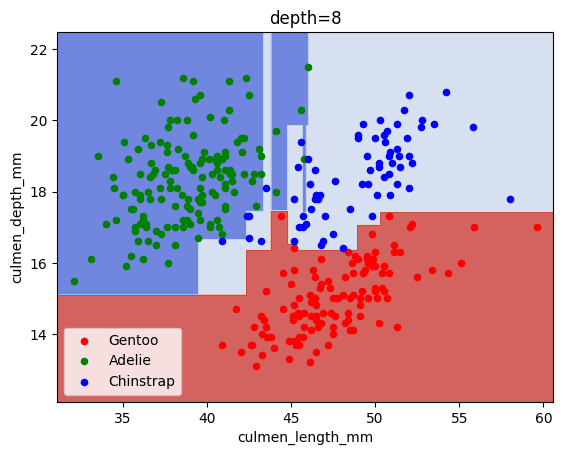

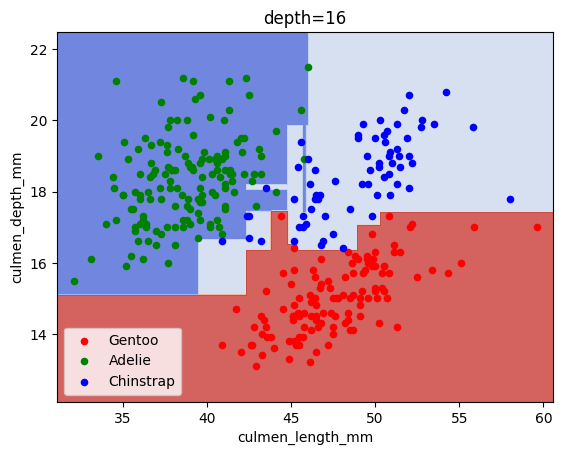

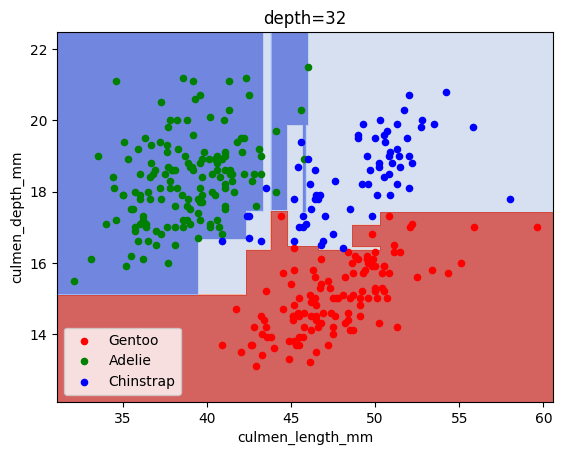

In [6]:
depths = [1, 2, 4, 8, 16, 32]

for d in depths:
    from sklearn.tree import DecisionTreeClassifier

    clf = DecisionTreeClassifier(max_depth=d)

    X, Y = data[['culmen_length_mm', 'culmen_depth_mm']], data['species']

    clf.fit(X, Y)
    plot_decision_region(clf, X, Y, f'depth={d}', 'culmen_length_mm', 'culmen_depth_mm', classes=["Gentoo", "Adelie", "Chinstrap"])

Che cosa sta succedendo all'albero? Come mai il numero di divisioni cambia così? Se aumentassimo ancora il numero di divisioni, quante foglie otterrei?